In [1]:
from fastai import *
from fastai.tabular import *
from fastai.tabular.data import *

In [2]:
import pandas as pd
from collections import Counter

In [3]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/NSLKDD/NSLKDD_Full.csv'
dataset = pd.read_csv(path)

### ***PRE-ELABORAZIONE DEI DATI***

In [4]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [5]:
dataset.head()

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,binlabel,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,anomaly,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,normal,normal


In [6]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder delle due variabili target, quindi da stringhe a interi sia in test che in train e salvo i valori nelle variabili y_test a y_train
# y_test viene utilizzata per la valutazione del modello

y_train_bin = LabelEncoder().fit_transform(train['binlabel'])
y_train = LabelEncoder().fit_transform(train['label'])
y_test_bin = LabelEncoder().fit_transform(test['binlabel'])
y_test = LabelEncoder().fit_transform(test['label'])

# tolgo la colonna 'binlabel' perché è una sotto variabile target
train = train.drop(['binlabel'], axis=1)
test = test.drop(['binlabel'], axis=1)

# sostituisco i valori originari con la codifica precedentemente fatta
target_index = train.columns.get_loc('label')
train.iloc[:, target_index] = y_train

# elimino la colonna relativa al target nel dataset di test poiché non utile
test = test.drop('label', axis=1)

In [11]:
train.head()

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
56874,5,tcp,smtp,SF,1507,371,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.0,75,211,0.91,0.04,0.01,0.01,0.0,0.0,0.0,0.0,21,2
68307,0,tcp,ftp_data,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,273,24,1.0,1.0,0.0,0.0,0.09,0.05,0.0,255,24,0.09,0.05,0.00,0.00,1.0,1.0,0.0,0.0,18,0
89354,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,218,14,1.0,1.0,0.0,0.0,0.06,0.06,0.0,255,7,0.03,0.07,0.00,0.00,1.0,1.0,0.0,0.0,21,0
118998,0,tcp,ssh,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116,6,0.0,0.0,1.0,1.0,0.05,0.08,0.0,255,6,0.02,0.08,0.00,0.00,0.0,0.0,1.0,1.0,20,0
85130,0,tcp,efs,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,110,5,1.0,1.0,0.0,0.0,0.05,0.06,0.0,255,5,0.02,0.07,0.00,0.00,1.0,1.0,0.0,0.0,21,0


In [8]:
test.head()

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
118874,0,tcp,http,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.0,1.00,1.0,1.00,0.00,0.00,1,7,1.00,0.00,1.00,0.57,0.0,0.0,1.00,1.0,21
79921,0,tcp,link,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,137,15,1.00,1.0,0.00,0.0,0.11,0.06,0.00,255,5,0.02,0.08,0.00,0.00,1.0,1.0,0.00,0.0,20
7458,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,8,0.00,0.0,1.00,1.0,0.07,0.07,0.00,255,28,0.11,0.06,0.00,0.00,0.0,0.0,1.00,1.0,18
24833,0,tcp,http,SF,235,4547,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,12,0.00,0.0,0.00,0.0,1.00,0.00,0.17,228,228,1.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,21
69403,0,udp,private,SF,28,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80,78,0.01,0.0,0.01,0.0,0.98,0.04,0.00,255,78,0.31,0.02,0.31,0.00,0.0,0.0,0.52,0.0,16


### ***MODEL***

In [15]:
""" Definisco delle variabili utili al nostro modello per saper come trattare i dati. 
  Distinguendo variabile target, continue e categoriali. 
  Inoltre in procs vengono passati degli ottimizzatori che vengono applicati ai dati prima del training: in particolare con FillMissing vengono sostituiti
  eventuali valori NaN, Categorify si occupa di codificare le variabili categoriali e Normalize si occupa di normalizzare i valori continui."""

dep_var = 'label'
cat_names = ["protocol_type", "service", "flag"]
cont_names = [col for col in train.columns if col not in cat_names]
cont_names.remove('label')
procs = [FillMissing, Categorify, Normalize]

In [13]:
# Splitto il dataset in train=80%, valid = 20%
from sklearn.model_selection import train_test_split

def SplitSet(df):
     #train, test = train_test_split(df, test_size=0.1)
     train, valid = train_test_split(df, test_size=0.20)
     split_val = len(train)
     train = train.append(valid)
     #return train, test, split_val
     return train, split_val

traindf, idx = SplitSet(train)

In [16]:
# Lista da passare al nostro tabular learner per effettuare la fase di test
test = TabularList.from_df(test, cat_names= cat_names, cont_names=cont_names, procs=procs)

# Lista contenete gli insiemi di training e validation, necessari per l'addrestamento del modello
data = TabularList.from_df(traindf, cat_names= cat_names, cont_names=cont_names, procs=procs)
data = data.split_by_idx(list(range(idx, len(traindf))))
data = data.label_from_df(cols=dep_var)
data = data.add_test(test, label= 0)
data = data.databunch()

# Creazione del nostro modello con due Hidden layers da, rispettivamente, 200 e 100 neuroni.
# Per valutare la performance durante l'addestramento viene usata l'accuratezza
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, emb_drop=0.01, callback_fns=ShowGraph)

In [17]:
""" Visualizziamo la struttura del modello """
learn

Learner(data=TabularDataBunch;

Train: LabelList (59406 items)
x: TabularList
protocol_type tcp; service domain; flag REJ; duration -0.1120; symbolic -0.0064; src_bytes -0.0070; dst_bytes -0.0130; DoS -0.0860; wrong_fragment -0.0110; urgent -0.0958; hot -0.0614; num_failed_logins -0.8191; logged_in -0.0184; num_compromised -0.0392; root_shell -0.0244; su_attempted -0.0185; num_root -0.0273; num_file_creations -0.0185; num_shells -0.0420; num_access_files 0.0000; num_outbound_cmds -0.0058; is_host_login -0.1122; is_guest_login 1.6248; count -0.2711; srv_count -0.5947; serror_rate -0.5903; srv_serror_rate 2.5502; rerror_rate 2.5327; srv_rerror_rate -1.4751; same_srv_rate -0.0395; diff_srv_rate -0.3781; srv_diff_host_rate 0.7185; dst_host_count -1.0057; dst_host_srv_count -1.1300; dst_host_same_srv_rate -0.0682; dst_host_diff_srv_rate -0.4741; dst_host_same_src_port_rate -0.2820; dst_host_srv_diff_host_rate -0.5979; dst_host_serror_rate -0.5852; dst_host_srv_serror_rate 2.6878; dst_host_r

### ***TRAINING***

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


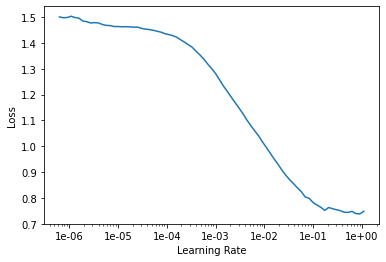

In [18]:
"""Troviamo il valore di learning rate da utilizzare per l'algoritmo di discesa del gradiente. 
  Prendiamo un valore mediano rispetto al punto di max pendenza """
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.057764,1.209018,0.975020,00:12
1,0.038003,0.937113,0.984379,00:12
2,0.024328,7.132314,0.992324,00:12
3,0.012260,2.130674,0.994546,00:12
4,0.012022,1.460750,0.995691,00:12


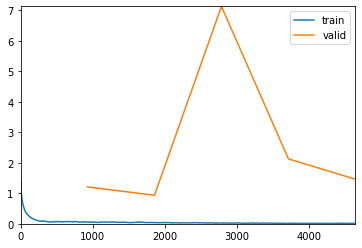

In [19]:
# Addestramento del modello
learn.fit_one_cycle(5, 1e-02, wd=0.02)

### ***PREDICTION***

In [20]:
# Valutazione del dataset di test ottenuto splittando il dataset di train
import numpy as np

pred, *_ = learn.get_preds(DatasetType.Test)
label = np.argmax(pred, 1)

y_pred = np.array(label)

In [27]:
y_pred

array([2, 0, 0, 2, ..., 0, 2, 0, 1])

### ***EVALUATION***

In [21]:
count_test = []
for i in y_test:
    count_test.append(i)

count_pred = []
for i in y_pred:
    count_pred.append(i)
    
print('Test:', Counter(count_test))
print('Pred:', Counter(count_pred))

Test: Counter({2: 38556, 0: 26551, 1: 7022, 3: 2073, 4: 56})
Pred: Counter({2: 38490, 0: 26519, 1: 7094, 3: 2111, 4: 44})


In [22]:
# Matrice di confusione, accuracy, classification_report
from sklearn import metrics

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [31]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[47678    29]
  [   61 26490]]

 [[67132   104]
  [   32  6990]]

 [[35573   129]
  [  195 38361]]

 [[72071   114]
  [   76  1997]]

 [[74186    16]
  [   28    28]]]


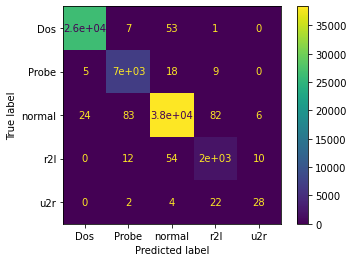

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

target_dict = {'Dos' : 0,
               'Probe' : 1,
               'normal' : 2,
               'r2l' : 3,
               'u2r' : 4}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [24]:
print(cm)

[[26490     7    53     1     0]
 [    5  6990    18     9     0]
 [   24    83 38361    82     6]
 [    0    12    54  1997    10]
 [    0     2     4    22    28]]


In [25]:
print(acc)

0.9947211074901021


In [26]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26551
           1       0.99      1.00      0.99      7022
           2       1.00      0.99      1.00     38556
           3       0.95      0.96      0.95      2073
           4       0.64      0.50      0.56        56

    accuracy                           0.99     74258
   macro avg       0.91      0.89      0.90     74258
weighted avg       0.99      0.99      0.99     74258

